## Ant metadata template
Extracts metadata like body measurements from a ```.mymridon``` experiment file and saves it as a csv, which can be further analyzed in the optional part or exported into other software such as RStudio. Script also shows how to link a ```tag_id``` (the "baracode") to the unique ```ant_id``` (internally attributed identifier for each ant) for a given period.  
How ant metadata is stored is documented in the [py-myrmidon documentation](https://formicidae-tracker.github.io/myrmidon/latest/api/index.html).

In [1]:
import py_fort_myrmidon as fm
from datetime import datetime, timedelta  # For convenient handling of time and date
import numpy as np  # Basic math library
import pandas as pd  # Used to create a dataframe, similar to the structure used in R

Timestamps in ```datetime``` format should be in local time, this is ensured by using ```.astimezone(tz=None) ```, more infos are [here](https://formicidae-tracker.github.io/myrmidon/latest/time.html#python-convertion-to-and-from-datetime-datetime).

In [2]:
f_myrmidon = "/home/user/Documents/experiment_folder/exp.myrmidon"
exp = fm.Experiment.Open(f_myrmidon)
t_start = datetime(2021, 2, 18, 0, 1).astimezone(tz=None)  # <year, month, day, hour, minute>
t_end = datetime(2021, 2, 20, 23, 59).astimezone(tz=None)

Add a ```tag_id``` column to the dataframe. This is the "barcode" id of the ant at ```t_start```. Note that the ```tag_id``` could change before ```t_end```.

In [3]:
df_metadata = pd.DataFrame(index=exp.Ants)
df_metadata["tag_id"] = np.nan
for ant in exp.Ants:
    # exp.Ants is a python dictionary containing fm.ant objects
    df_metadata.loc[ant, "tag_id"] = exp.Ants[ant].IdentifiedAt(fm.Time(t_start))

Extract basic ant metadata.

In [4]:
print(exp.MeasurementTypeNames)  # Returns a dictionary with {integer_id: name} of a body measurement 
print(exp.HEAD_TAIL_MEASUREMENT_TYPE_ID)  # Returns the integer_id of the mandatory head-tail measurement

df_metadata["head_tail_px"] = np.nan
for ant in exp.Ants:
    head_tail_pixels = fm.Query.ComputeMeasurementFor(experiment=exp,
                                                      antID=ant,
                                                      measurementTypeID=exp.HEAD_TAIL_MEASUREMENT_TYPE_ID)
    df_metadata.loc[ant, "head_tail_px"] = head_tail_pixels[0].LengthPixel

{1: 'head-tail'}
1


The following function defines what is called an "iterator function" in python. When defined like here, it can be used to create a loop over days in some datetime range. Unlike the built-in ```range(n)``` iterator (which creates the range ```(1,...,n-1)```), this iterator will include the last element and yield a range ```(t_start,...,t_end)```. It is good practice to load and process any tracking data daywise to avoid memory problems.

In [5]:
def fm_time_range(start_datetime, end_datetime):
    for n in range(int((end_datetime - start_datetime).days) + 1):
        yield fm.Time(start_datetime + timedelta(n))

Extract the number of detections in period (```t_begin```, ```t_begin + 24h```). Note that the counts listen in a query result from ```fm.Query.staticComputeTagStatistics``` are tag, i.e. "barcode" counts, from which it is not directly possible to find the counts of an ant during a given period. Instead we query and summarize trajectories.

In [6]:
df_metadata["counts"] = 0
for t_begin in fm_time_range(t_start, t_end):
    print("sub-period start: {}".format(t_begin.ToDateTime()))
    trajectories = fm.Query.ComputeAntTrajectories(experiment=exp,
                                                   start=t_begin,
                                                   end=t_begin.Add(fm.Duration.Parse('24h')))
    for t in trajectories:
        df_metadata.loc[t.Ant, "counts"] += len(t.Positions)

sub-period start: 2021-02-18 00:01:00
sub-period start: 2021-02-19 00:01:00
sub-period start: 2021-02-20 00:01:00


Save dataframe and optionally plot.

In [7]:
f_name = "ant_metadata_{}_{}_{}.csv".format(exp.Name, t_start, t_end)
df_metadata.to_csv(f_name, index_label='ant_id')
print(df_metadata[:10].to_markdown())  # Show csv preview

|    |   tag_id |   head_tail_px |           counts |
|---:|---------:|---------------:|-----------------:|
|  1 |        1 |        269.268 | 129636           |
|  2 |        5 |        277.51  | 618618           |
|  3 |        6 |        297.901 |  59079           |
|  4 |        7 |        295.665 | 214084           |
|  5 |       10 |        308.11  |      1.56917e+06 |
|  6 |       11 |        189.188 |  65153           |
|  7 |       13 |        284.823 |      1.61327e+06 |
|  8 |       14 |        324.039 | 237303           |
|  9 |       21 |        294.635 |      1.32261e+06 |
| 10 |       24 |        317.289 | 802683           |


<AxesSubplot:xlabel='tag_id'>

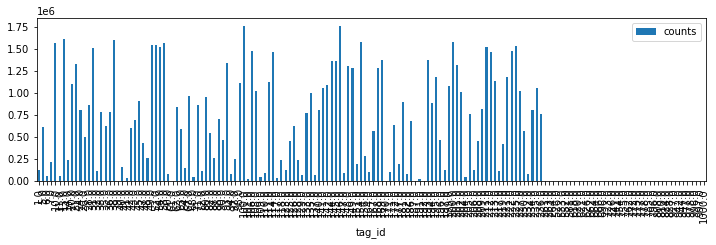

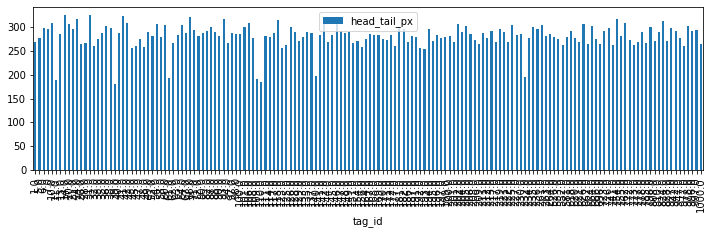

In [8]:
df_metadata.pivot_table(values='counts', index='tag_id').plot(kind='bar', figsize=(12,3))
df_metadata.pivot_table(values='head_tail_px', index='tag_id').plot(kind='bar', figsize=(12,3))